In [3]:
import pandas as pd
import numpy as np
import nltk
import json
import io
import dateutil
import re
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
import itertools
import warnings

from nltk.tokenize import word_tokenize
from string import punctuation
from nltk.corpus import stopwords
from wordcloud import WordCloud


warnings.filterwarnings("ignore")
sns.set()
plt.rcParams["font.serif"] = "cmr10"

# Graphics in retina format are more sharp and legible
%config InlineBackend.figure_format = 'retina'

In [4]:
stop_words = set(
    stopwords.words('english') + list(punctuation) + ['AT_USER', 'URL'])

In [7]:
def get_tweets_from_json_file(mode):
    """
    :param mode: can be "kcca", "moh", "influencers", "moh_engagement" e.t.c depending on the data being analyzed
    """
    filename = "{}_analysis_tweets.json".format(mode)
    with io.open(filename, 'r', encoding='utf-8') as f:
        json_data = json.load(f)
        f.close()
    return json_data['tweets']

In [67]:
influencer_tweets = get_tweets_from_json_file("influencers")

In [68]:
print("Number of tweets: {}".format(len(influencer_tweets)))

Number of tweets: 8821


In [10]:
def get_tweet_words(tweet):
    """Clean up tweet"""
    
    tweet = tweet.lower()  # convert text to lower-case
    tweet = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', 'URL',
                   tweet)  # remove URLs
    tweet = re.sub('@[^\s]+', 'AT_USER', tweet)  # remove usernames
    tweet = re.sub(r'#([\w]+)', '', tweet)  # remove the # in #hashtag
    tweet = word_tokenize(
        tweet)  # remove repeated characters (helloooooooo into hello)
    return [word for word in tweet if word not in stop_words and len(word) > 3]


def is_retweet(tweet):
    if "referenced_tweets" in tweet:
        ref_tweets = tweet["referenced_tweets"]
        return len(ref_tweets) == 1 and ref_tweets[0]['type'] == 'retweeted' 
    return False

def filter_tweets(tweets):
    return [tweet for tweet in tweets if not (is_retweet(tweet) or tweet['username'].isnumeric())]


def process_tweet(tweet):
    """Process tweets from raw files"""
    username = tweet['username']
    user_id = tweet['user_id']
    tweet_id = tweet['id']
    created_time = dateutil.parser.parse(
        tweet['created_at']).replace(tzinfo=None)
    text = tweet['text']
    words = get_tweet_words(text)
    retweet_count = tweet['public_metrics']['retweet_count']
    reply_count = tweet['public_metrics']['reply_count']
    quote_count = tweet['public_metrics']['quote_count']
    like_count = tweet['public_metrics']['like_count']
    engagement = retweet_count + reply_count + quote_count + like_count
#     followers_count = tweet['user']['followers_count']
    return {
        'username': username,
        'user_id': user_id,
        'tweet_id': tweet_id,
        'created_time': created_time,
        'text': text,
        'words': words,
        'retweet_count': retweet_count,
        'reply_count': reply_count,
        'quote_count': quote_count,
        'like_count': like_count,
        'engagement': engagement
    }


def create_pd_frame(tweets):
    filtered_tweets = filter_tweets(tweets)
    df = pd.DataFrame([process_tweet(tweet) for tweet in filtered_tweets])
    df.set_index('created_time', inplace=True)
    return df

In [69]:
df = create_pd_frame(influencer_tweets)

In [70]:
df.shape

(4929, 10)

In [71]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4929 entries, 2020-09-24 18:43:41 to 2020-10-11 13:21:49
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   username       4929 non-null   object
 1   user_id        4929 non-null   object
 2   tweet_id       4929 non-null   object
 3   text           4929 non-null   object
 4   words          4929 non-null   object
 5   retweet_count  4929 non-null   int64 
 6   reply_count    4929 non-null   int64 
 7   quote_count    4929 non-null   int64 
 8   like_count     4929 non-null   int64 
 9   engagement     4929 non-null   int64 
dtypes: int64(5), object(5)
memory usage: 327.3+ KB


In [72]:
df.head()

,username,user_id,tweet_id,text,words,retweet_count,reply_count,quote_count,like_count,engagement
created_time,,,,,,,,,,
2020-09-24 18:43:41,Usual Suspect 🎩 @Jude_Mugabi,712676897,1309201856627978240,RT @Ozelle_Kayom: https://t.co/PAXzxMc1nq,[],4,0,0,0,4
2020-09-24 18:46:50,Canary Mugume @CanaryMugume,285577145,1309202652094439424,The home workstation I need 😫. https://t.co/Rp...,"[home, workstation, need]",16,16,2,206,240
2020-09-24 19:06:43,Maurice Mugisha @MauriceMugisha,403563397,1309207654498172928,"OK, city what? 😆 https://t.co/3iWtxldjB5",[city],6,12,2,45,65
2020-09-24 19:07:19,Canary Mugume @CanaryMugume,285577145,1309207806298460166,"@qataharraymond Loan me, I give you some ka mo...","[loan, give, money]",0,0,0,20,20
2020-09-24 19:12:51,Aƙҽɳα Mαɾƚιɳ @akmartos1,992050985370517505,1309209197020672001,They will run away from @NUP_Ug one by one 👍 a...,"[away, reminder, vote, president, 2021-2026]",2,1,0,9,12


### Comparing the different influencers

The following plot shows the number of tweets each influencer had (exluding retweets).

In [73]:
usernames = list(df['username'])
usernames_freq = nltk.FreqDist(usernames)
usernames_df = pd.DataFrame({
    'Username': list(usernames_freq.keys()),
    'Count': list(usernames_freq.values())
})

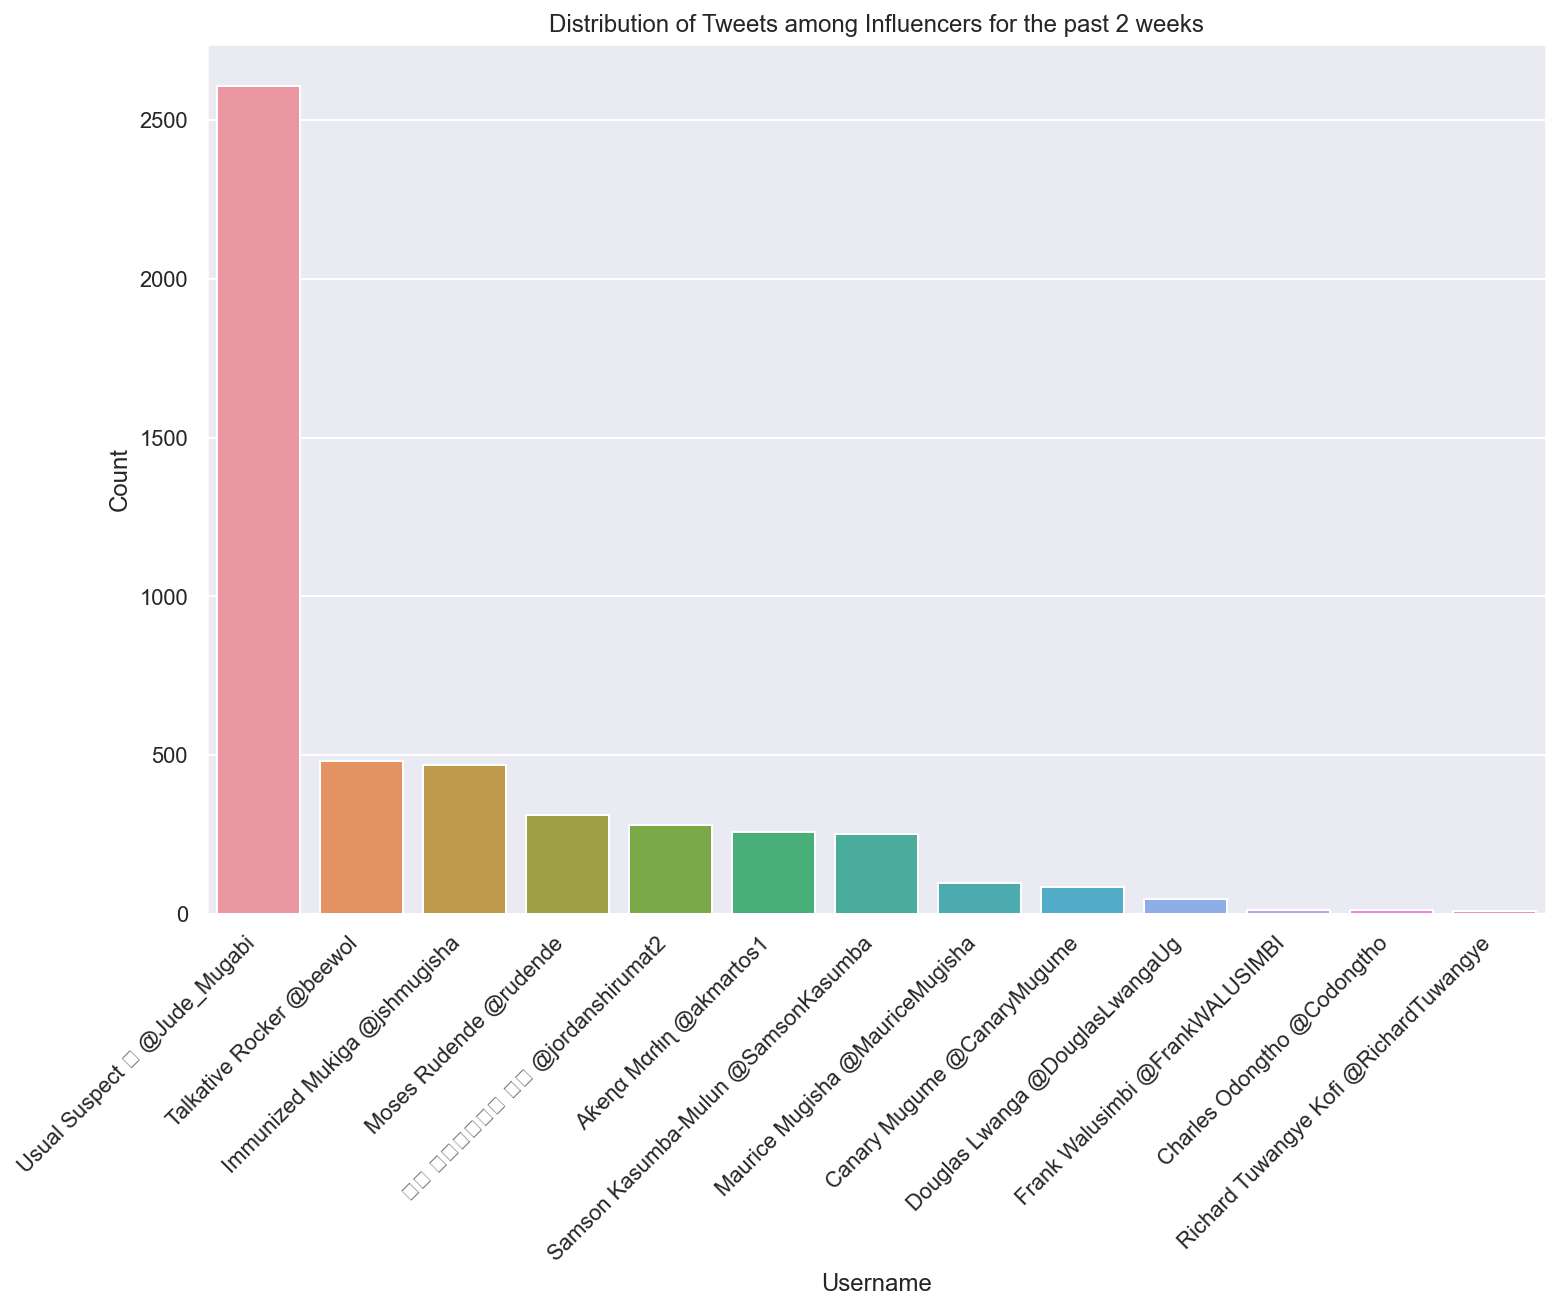

In [74]:
popular_users = usernames_df.nlargest(columns='Count', n=13)
_, axes = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))

ax = sns.barplot(x='Username', y='Count', data=popular_users, ax=axes)
ax.set(ylabel="Count")
ax.set_title("Distribution of Tweets among Influencers for the past 2 weeks")
ax.set_xticklabels(ax.get_xticklabels(),
                  rotation=45,
                  horizontalalignment='right')
plt.show()

Engagement that each influencer receives on their tweets.

**NOTE**: Engagement is the total number of retweets, replies, quotes and likes

In [75]:
columns_to_show = ["username", "retweet_count", "reply_count", "quote_count", "like_count", "engagement"]

eng_df = df.groupby(['username'])[columns_to_show]

In [76]:
aggregate = eng_df.agg([np.mean])
average_engagement_df = pd.DataFrame({
    "Username": list(eng_df.groups.keys()),
    "Average Engagement": list(aggregate[('engagement', 'mean')])
})

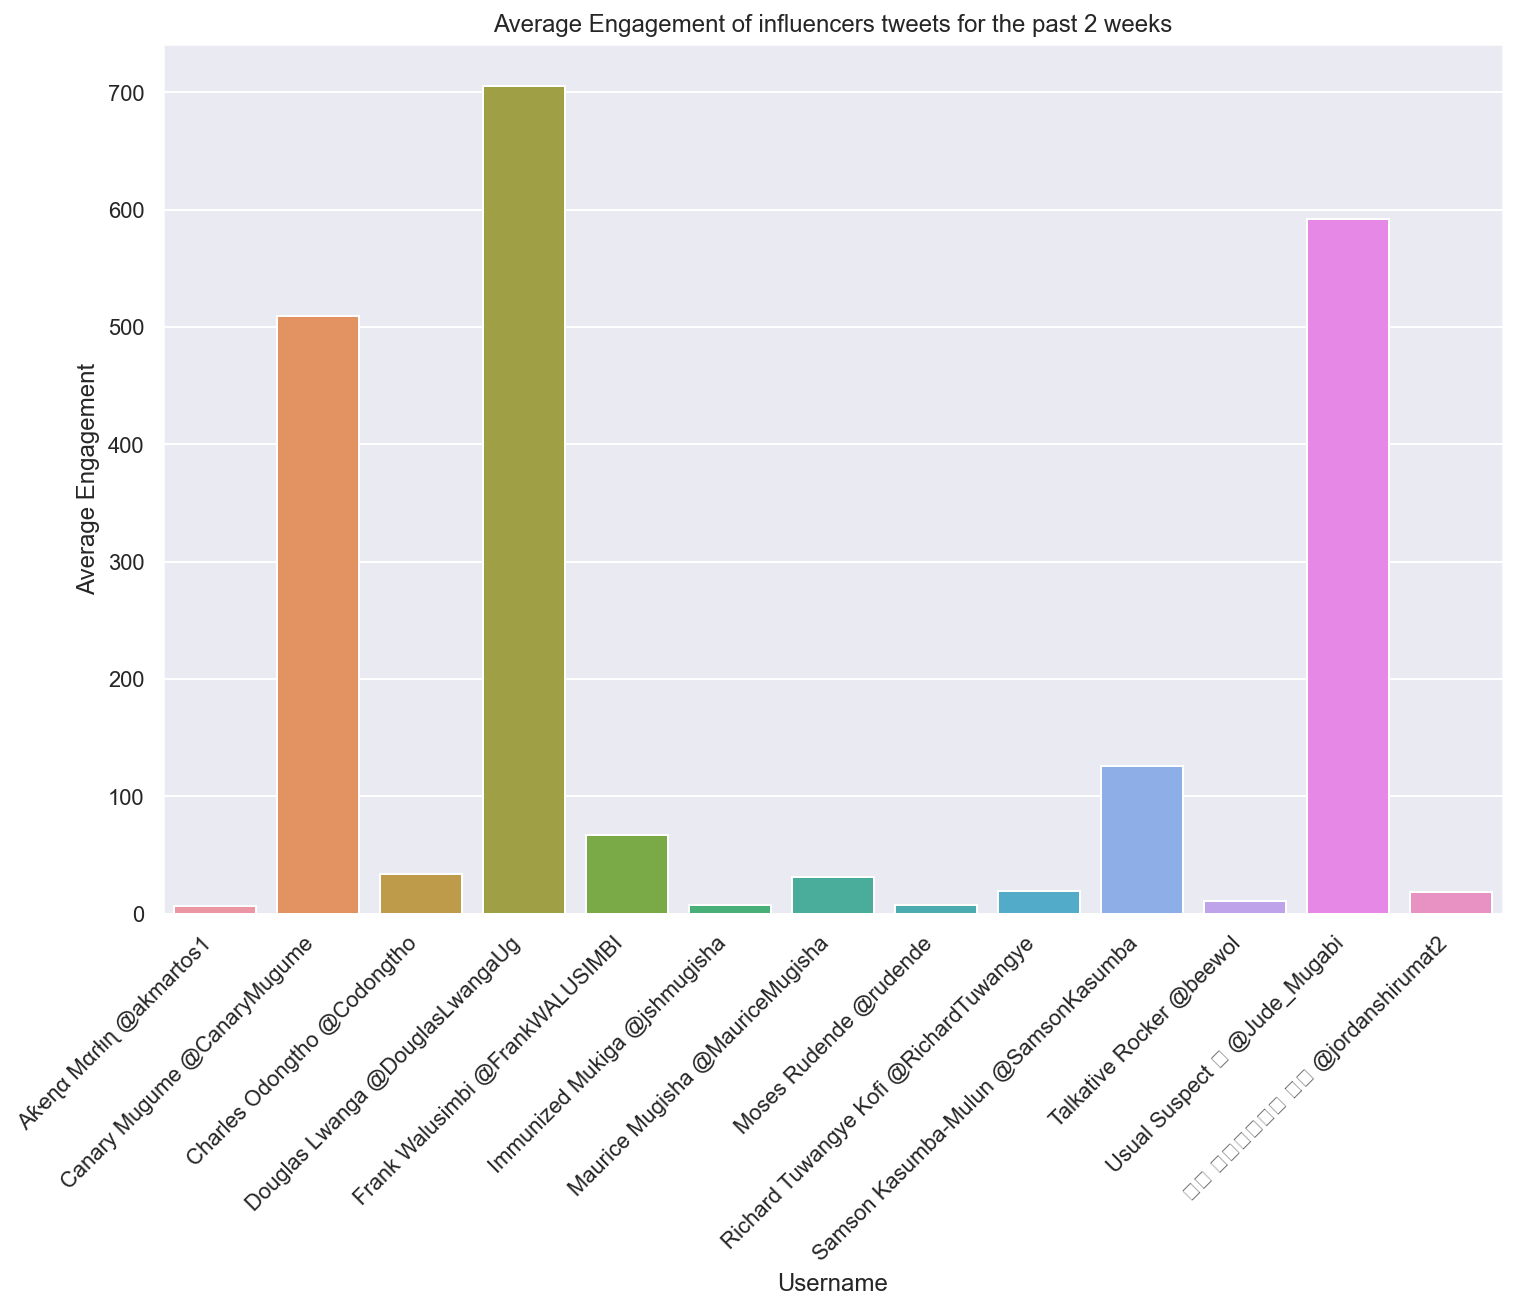

In [77]:
_, axes = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))

ax = sns.barplot(x='Username', y="Average Engagement", data=average_engagement_df, ax=axes)
ax.set(ylabel='Average Engagement')
ax.set_title("Average Engagement of influencers tweets for the past 2 weeks")
ax.set_xticklabels(ax.get_xticklabels(),
                  rotation=45,
                  horizontalalignment='right')
plt.show()

## Analysis of COVID tweets

In [78]:
covid_words = ["covid", "covid19", "corona", "coronavirus", "mask", "masks", "lockdown", 
               "staysafe", "virus", "cov", "stayhome", "staysafeug", "socialdistance", "washyourhands", "wearamask"]
def is_covid_related_tweet(tweet_words):
    for word in covid_words:
        if word in tweet_words:
            return True
    return False

In [79]:
covid_tweets = df[df['words'].apply(lambda t_words: is_covid_related_tweet(t_words))]

In [80]:
covid_tweets.head()

,username,user_id,tweet_id,text,words,retweet_count,reply_count,quote_count,like_count,engagement
created_time,,,,,,,,,,
2020-09-25 04:32:32,Richard Tuwangye Kofi @RichardTuwangye,623892369,1309350047348412417,"BANANGE, wear the Mask in Public and the Condo...","[banange, wear, mask, public, condom, pubic, a...",2,0,0,12,14
2020-09-25 20:49:00,🇺🇬 𝐉𝐎𝐑𝐃𝐀𝐍 🇺🇬 @jordanshirumat2,715891118672646144,1309595783772200960,@MauriceMugisha No covid on the mic 👏🏿,[covid],0,0,0,1,1
2020-09-26 06:56:15,Usual Suspect 🎩 @Jude_Mugabi,712676897,1309748602504441856,RT @julieimmy: What's the obsession with these...,"[obsession, double, cabin, pickups, state, hea...",4,0,0,0,4
2020-09-26 08:13:22,Usual Suspect 🎩 @Jude_Mugabi,712676897,1309768009058312194,IRRESPONSIBLE LENDING AND INSIDER TRADING: How...,"[irresponsible, lending, insider, trading, ⁦AT...",44,8,7,69,128
2020-09-28 06:30:55,Usual Suspect 🎩 @Jude_Mugabi,712676897,1310467001077334016,Taking account the laxity witnessed in observa...,"[taking, account, laxity, witnessed, observanc...",3,0,0,6,9


In [82]:
covid_tweets.shape # 45 tweets about covid

(45, 10)

### Frequency of covid tweets

In [83]:
daily_covid = covid_tweets['tweet_id'].groupby([covid_tweets.index.date]).count()

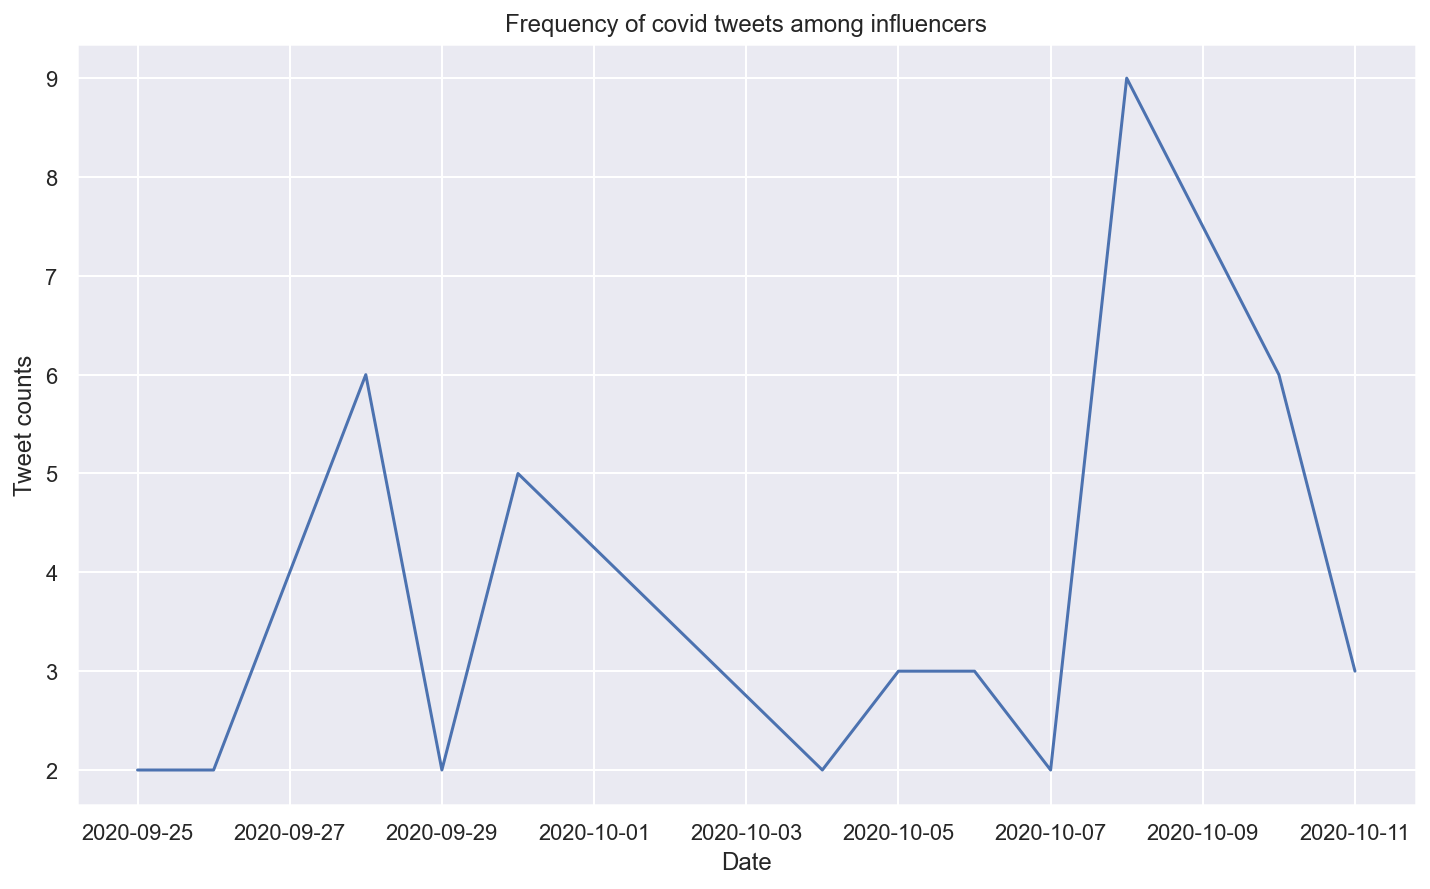

In [84]:
ax = daily_covid.plot(figsize=(12, 7))

ax.set(title="Frequency of covid tweets among influencers")
ax.set(ylabel="Tweet counts")
ax.set(xlabel="Date")

plt.show()

### Analysis of words in the influencers tweets for the last week

In [85]:
tweet_words = list(itertools.chain.from_iterable(df['words']))

In [86]:
wordcloud = WordCloud(width=800, height=500, random_state=20, max_font_size=110).generate(' '.join(tweet_words))

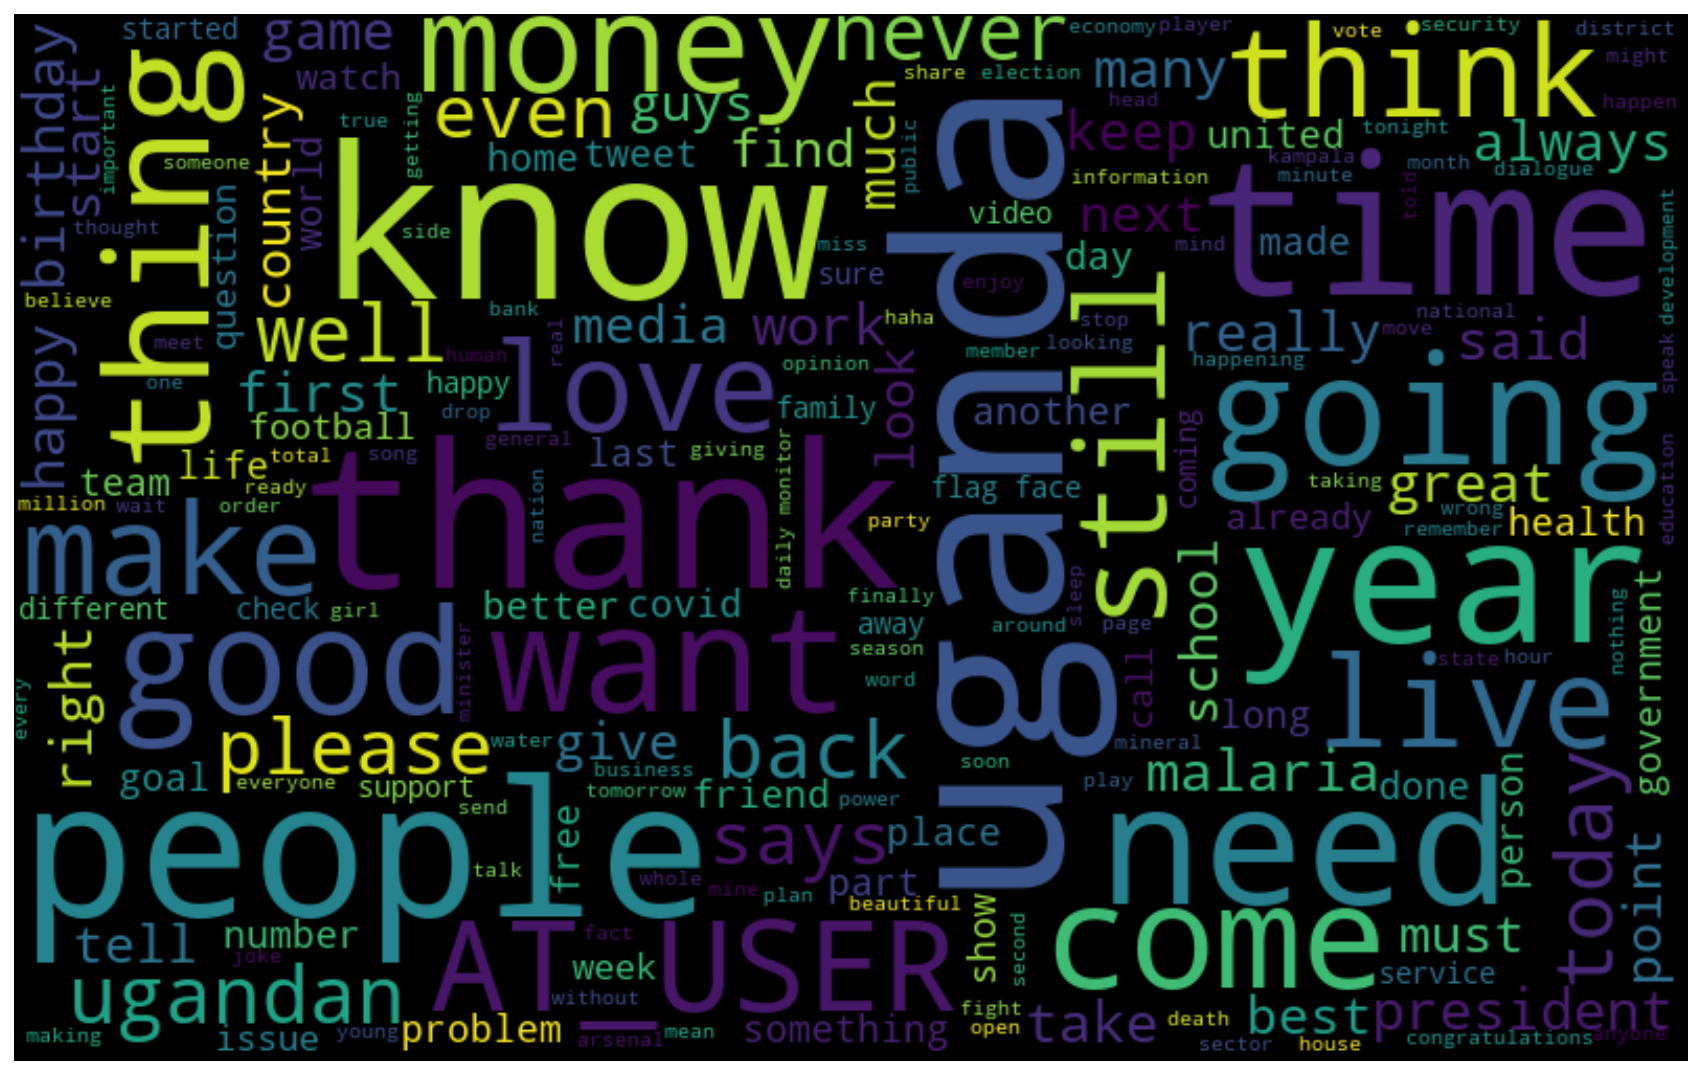

In [87]:
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()